### Step 1: Setup & Load Data

In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For better plots inline in Jupyter
%matplotlib inline

# Step 2: Load the data
data_path = "Telco-Customer-Churn.csv"  # Make sure your file is in the same folder or give full path
df = pd.read_csv(data_path)

# Step 3: Basic exploration
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nInfo about columns:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())


Dataset shape: (7043, 21)

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Streami

### Data Cleaning & Preparing for Modeling

In [2]:
# Step 4: Fix TotalCharges column
# Convert to numeric, coerce errors to NaN (non-convertible values will become NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for NaNs created by coercion
print("Number of missing values in TotalCharges after conversion:", df['TotalCharges'].isna().sum())

# Drop rows with NaN in TotalCharges (if any)
df = df.dropna(subset=['TotalCharges'])

# Step 5: Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Step 6: Encode categorical features
# Drop customerID as it's an identifier, not useful for modeling
df = df.drop('customerID', axis=1)

# List of categorical columns (object type)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", cat_cols)

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Step 7: Check cleaned dataset
print("Cleaned dataset shape:", df.shape)
print(df.head())


Number of missing values in TotalCharges after conversion: 11
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Cleaned dataset shape: (7032, 31)
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0        False   
1              0      34           56.95       1889.50      0         True   
2              0       2           53.85        108.15      1         True   
3              0      45           42.30       1840.75      0         True   
4              0       2           70.70        151.65      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False    

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

Confusion Matrix:
 [[916 117]
 [160 214]]
ROC AUC Score: 0.836


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


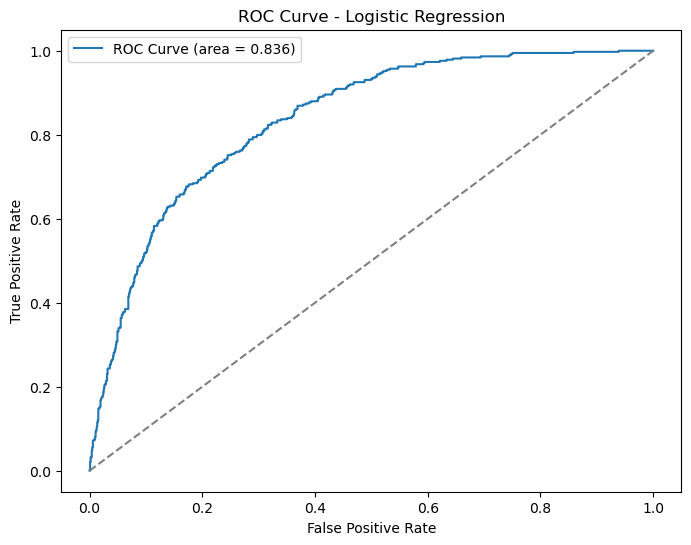

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Step 8: Split data into features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Step 9: Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 10: Initialize and train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 11: Predict on test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Step 12: Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.3f}")

# Step 13: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()


In [4]:
from sklearn.preprocessing import StandardScaler

# Scale numeric columns only
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']  # SeniorCitizen is numeric 0/1

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Train logistic regression again with scaled data
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407

Confusion Matrix:
 [[918 115]
 [159 215]]
ROC AUC Score: 0.836


In [5]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict & evaluate
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(f"Random Forest ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.3f}")


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Random Forest Confusion Matrix:
 [[917 116]
 [182 192]]
Random Forest ROC AUC Score: 0.816


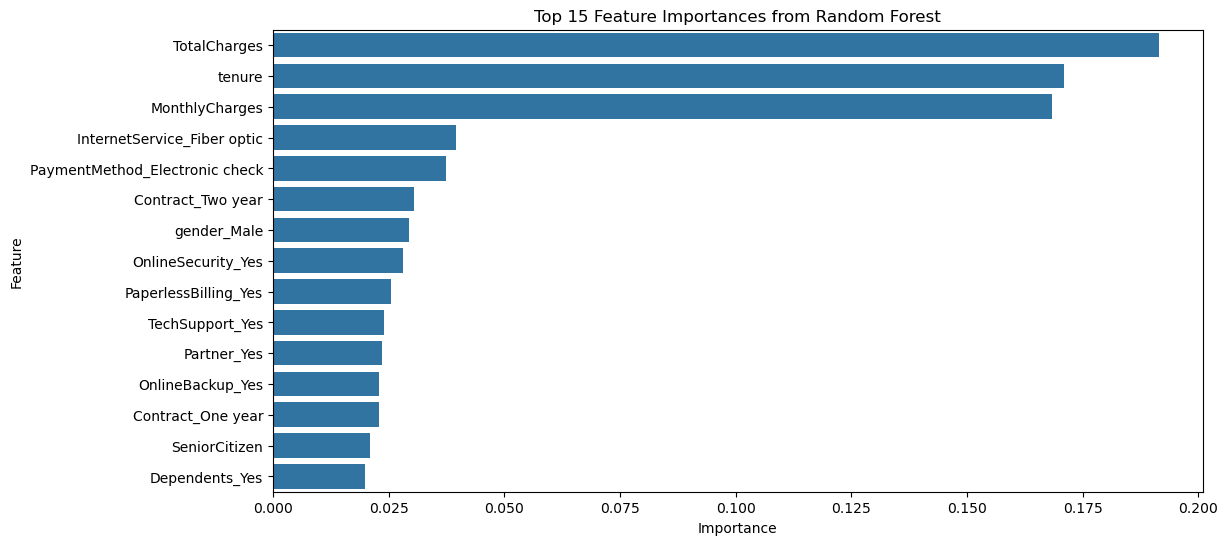

In [6]:
importances = rf_model.feature_importances_
features = X_train.columns

# Create a dataframe and sort
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
plt.title('Top 15 Feature Importances from Random Forest')
plt.show()


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best CV Score: 0.8046222222222222
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

[[923 110]
 [192 182]]
ROC AUC Score: 0.8322056623406204


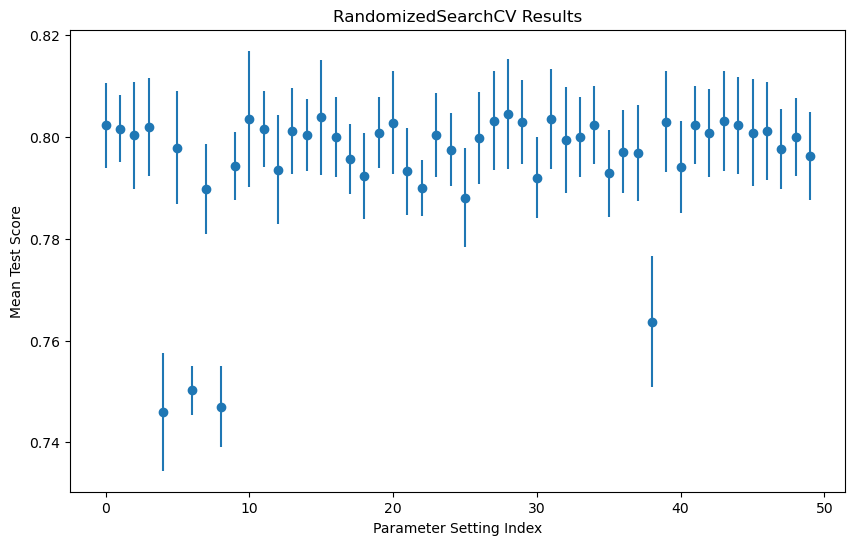

[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   1.9s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   4.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=50

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define your data here
# X_train, y_train, X_test, y_test = ...

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize base model
rf = RandomForestClassifier(random_state=42)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all CPUs
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters & best score
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

# Use best estimator to predict
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_pred_proba_best = best_rf.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_best))

# Plotting the results of RandomizedSearchCV
results = random_search.cv_results_

# Extract mean test scores and standard deviation for each parameter setting
mean_test_scores = results['mean_test_score']
std_test_scores = results['std_test_score']

# Plotting the mean test scores with error bars representing the standard deviation
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(mean_test_scores)), mean_test_scores, yerr=std_test_scores, fmt='o')
plt.xlabel('Parameter Setting Index')
plt.ylabel('Mean Test Score')
plt.title('RandomizedSearchCV Results')
plt.show()
